In [ ]:
import os
import matplotlib.pyplot as plt # type: ignore
import matplotlib.image as img # type: ignore

%matplotlib inline

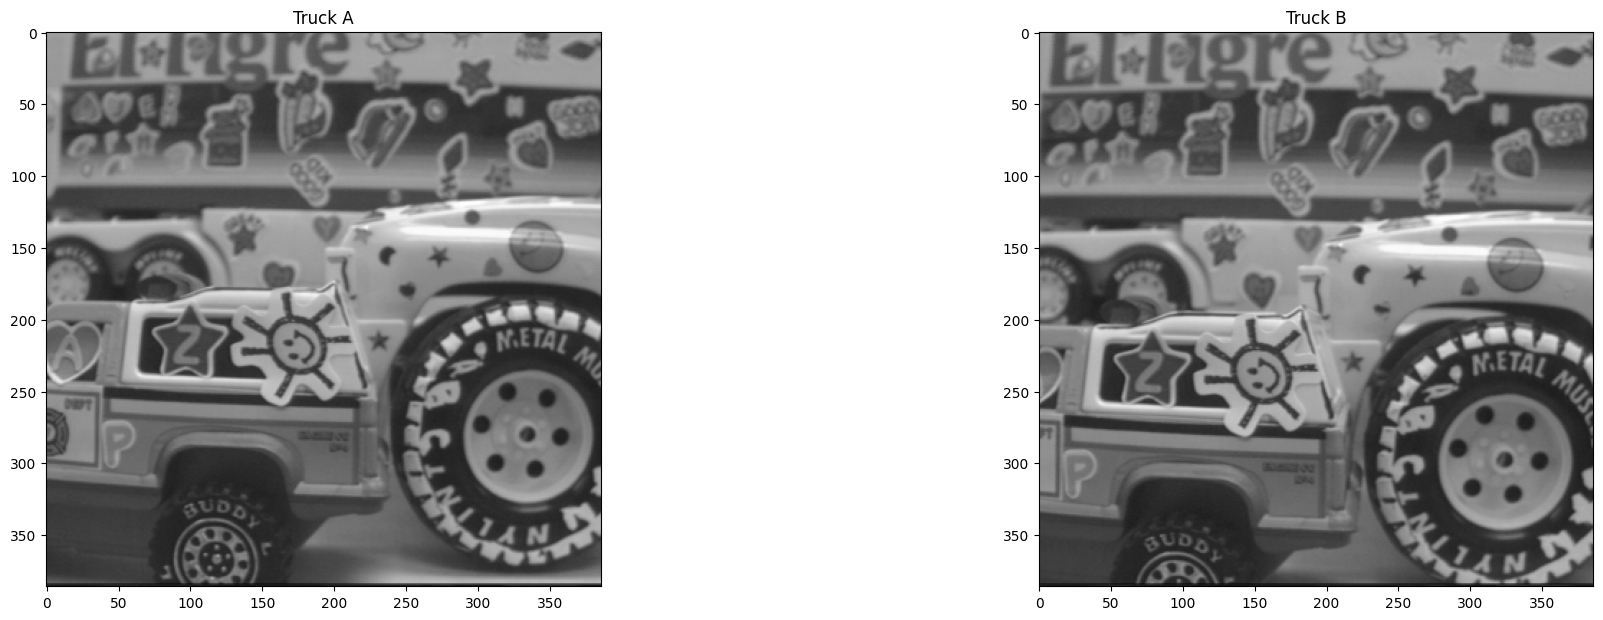

In [ ]:

# Load images using matplotlib
truck_a = img.imread("./data/trucka.bmp").astype("float")
truck_b = img.imread("./data/truckb.bmp").astype("float")

# Create a figure with specified size
plt.figure(figsize=(20, 12))

# Display the first image
plt.subplot(2, 2, 1)
plt.imshow(truck_a, cmap="gray")  # cmap: colormap, defaults to RGB(A) color space
plt.title("Truck A")

# Display the second image
plt.subplot(2, 2, 2)
plt.imshow(truck_b, cmap="gray")
plt.title("Truck B")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [8]:
def calculate_block_positions(image, window_height=8, window_width=8, stride=8):
    """
    Extract patches from the image with optimized performance.

    Args:
        image: The input image from which to extract patches.
        window_height (optional): Height of the patch. Defaults to 8.
        window_width (optional): Width of the patch. Defaults to 8.
        stride (optional): Step size for moving the window across the image. Defaults to 8.

    Returns:
        A tuple containing:
        - List of extracted patches.
        - List of positions (row, column) corresponding to each patch.
    """

    # Calculate maximum valid row and column indices
    max_row = len(image) - window_height + 1
    max_col = len(image[0]) - window_width + 1

    # Generate row and column indices with the given stride
    rows = list(range(0, max_row, stride))
    cols = list(range(0, max_col, stride))

    # Create positions list using list comprehension
    positions = [(r, c) for r in rows for c in cols]

    # Extract patches using list comprehension
    patches = []
    for r, c in positions:
        patch = []
        for i in range(window_height):
            row = []
            for j in range(window_width):
                row.append(image[r + i][c + j])
            patch.append(row)
        patches.append(patch)

    return patches, positions

In [9]:
def calculate_motion_and_positions(patch_list_a, position_tup_a, patch_list_b, position_tup_b, search_range=50):
    cell_size = search_range
    spatial_index = {}

    # Build the spatial index
    for position, patch in zip(position_tup_b, patch_list_b):
        cell_row = position[0] // cell_size
        cell_col = position[1] // cell_size
        cell_key = (cell_row, cell_col)

        if cell_key not in spatial_index:
            spatial_index[cell_key] = []
        spatial_index[cell_key].append((position, patch))

    motion_tup = []
    for patch_a, position_a in zip(patch_list_a, position_tup_a):
        # Find grid cell for this position
        cell_row = position_a[0] // cell_size
        cell_col = position_a[1] // cell_size

        cost = 999999
        match_position = None

        # Search in current and adjacent cells
        for dr in [-1, 0, 1]:
            for dc in [-1, 0, 1]:
                neighbor_cell = (cell_row + dr, cell_col + dc)

                if neighbor_cell not in spatial_index:
                    continue

                for position_b, patch_b in spatial_index[neighbor_cell]:
                    position_distance = ((position_a[0] - position_b[0])**2 +
                                          (position_a[1] - position_b[1])**2)**0.5

                    if position_distance <= search_range:
                        difference = 0
                        for i in range(len(patch_a)):
                          for j in range(len(patch_a[i])):
                            difference += abs(patch_a[i][j] - patch_b[i][j])
                        if difference <= cost:
                            cost = difference
                            match_position = position_b

        # If no match found within range, fallback to full search
        if match_position is None:
            for patch_b, position_b in zip(patch_list_b, position_tup_b):
                difference = 0
                for i in range(len(patch_a)):
                  for j in range(len(patch_a[i])):
                    difference += abs(patch_a[i][j] - patch_b[i][j])
                if difference <= cost:
                    cost = difference
                    match_position = position_b

        dr, dc = match_position[0] - position_a[0], match_position[1] - position_a[1]
        motion_tup.append((position_a, (dr, dc)))

    return motion_tup

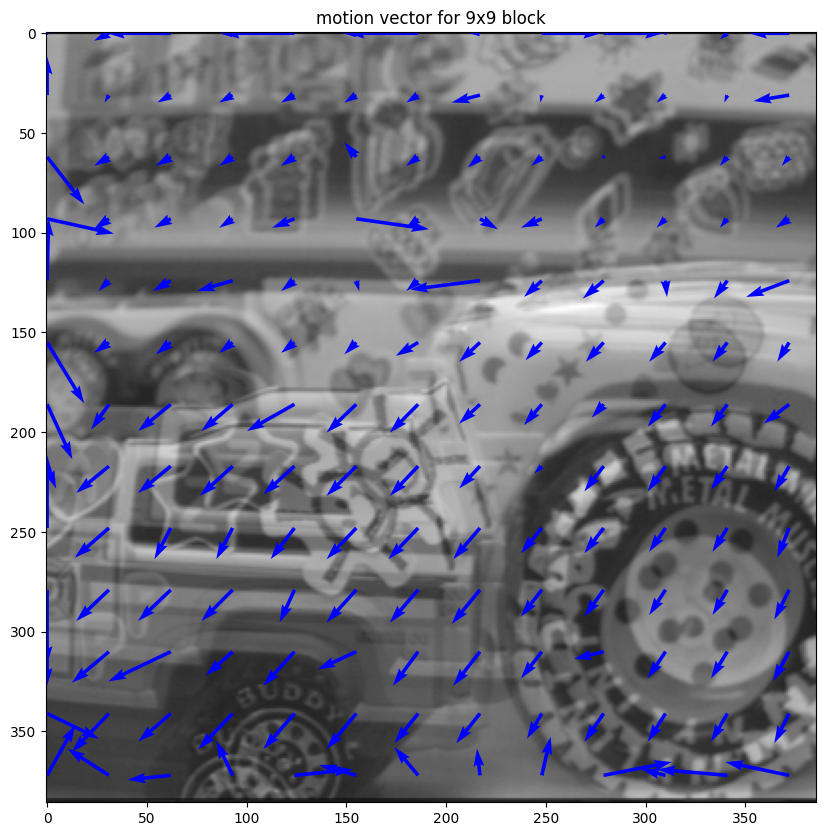

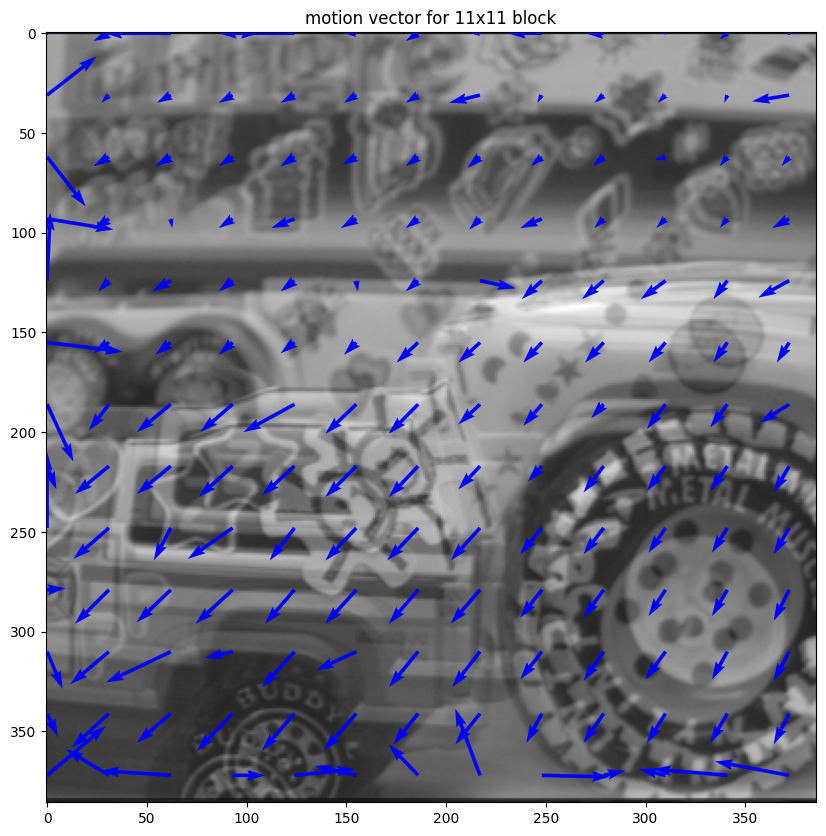

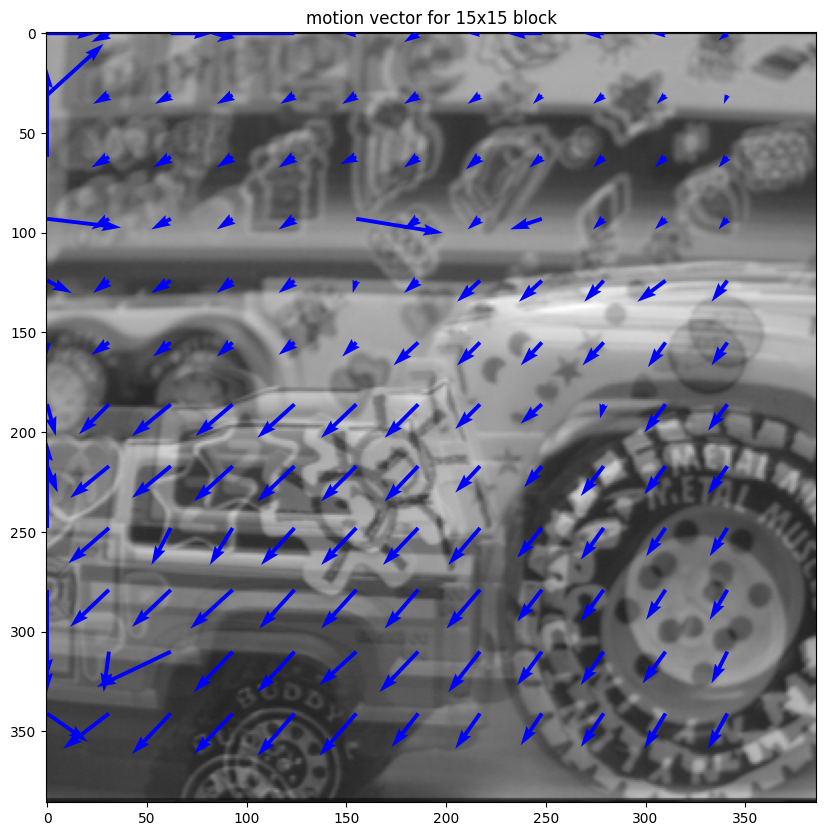

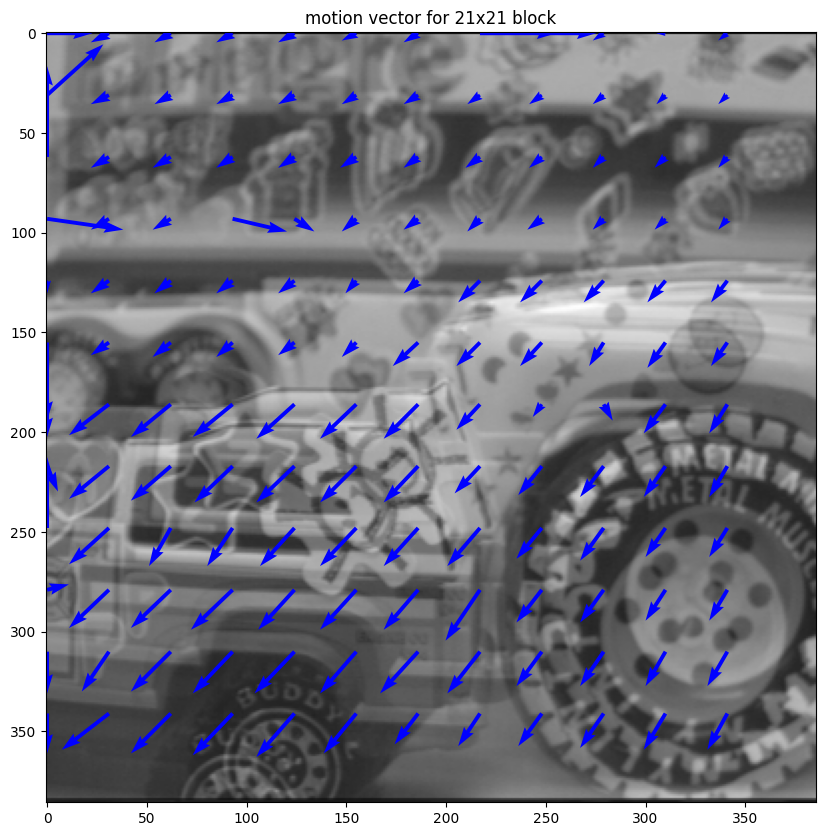

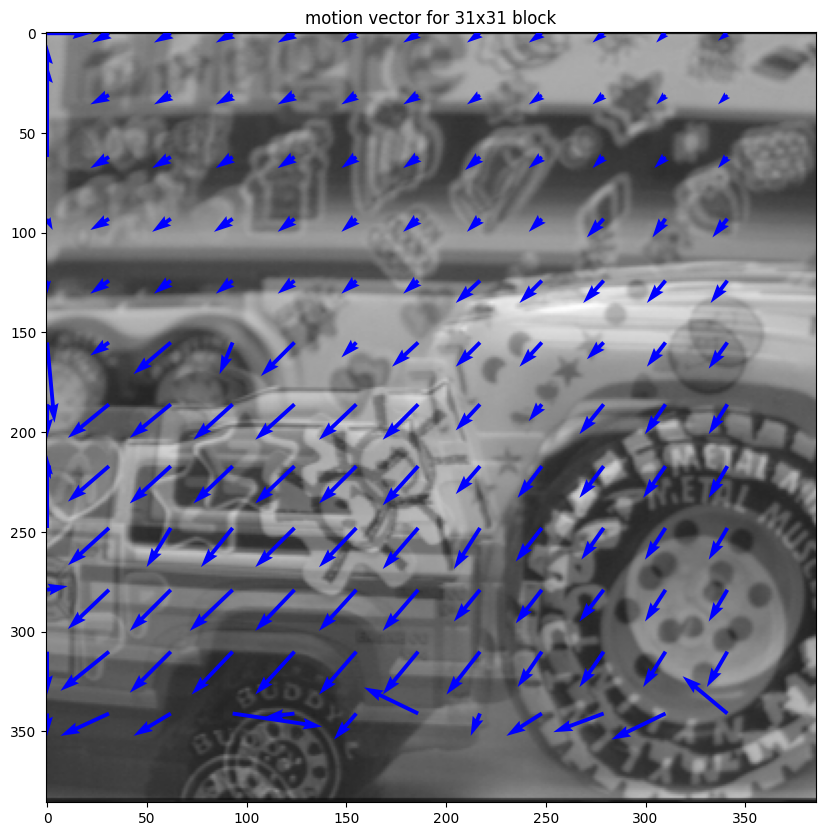

In [10]:
block_sizes = [9,11,15,21,31]
search_range = 50
window = 31

if not os.path.exists("./output_images"):
    os.makedirs("./output_images")

for i in range(len(block_sizes)):
    patch_a, position_a = calculate_block_positions(truck_a, block_sizes[i], block_sizes[i], stride=window)
    patch_b, position_b = calculate_block_positions(truck_b, block_sizes[i], block_sizes[i], stride=1)
    motion_vector = calculate_motion_and_positions(patch_a, position_a, patch_b, position_b, search_range)

    X, Y = zip(*[(arrow[0][1], arrow[0][0]) for arrow in motion_vector])  # Positions (x, y)
    U, V = zip(*[(arrow[1][1], -arrow[1][0]) for arrow in motion_vector])  # Vectors (u, v)

    plt.figure(figsize=(10,10))
    plt.imshow(0.5 * truck_a + 0.5 * truck_b, cmap="gray")
    plt.quiver(X, Y, U, V,color='b')
    plt.title("motion vector for {}x{} block".format(block_sizes[i],block_sizes[i]))

    plt.savefig("./output_images/block_{}_motion_vector.png".format(str(block_sizes[i])),  transparent=False)
    plt.show()